In [1]:
import numpy as np
import scipy
from collections import defaultdict
from sklearn.linear_model import LinearRegression

# Load pre-computed LOOCV regularization optimums for the simulation data
rr1_params = np.loadtxt('loocv-simulation-rr1-params.txt')
rrp_params = np.loadtxt('loocv-simulation-rrp-params.txt')

np.random.seed(1)

p = 3
beta = np.array([0.001, 0.1, 10.0])
feature_sigma = 1.0
sigma = 1.0

def generate_feature_matrix(n):
    return np.random.normal(scale=feature_sigma, size=(n, p))

def generate_target_vector(X):
    y_base = np.dot(X, beta)
    return y_base + np.random.normal(scale=sigma, size=X.shape[0])

train_sizes = list(range(8, 21))

models = {
    'LS' : LinearRegression(fit_intercept=False),
    'RR-1' : None, # set a single ridge regression regularizer to optimize the LOOCV (stub, not released yet)
    'RR-p' : None, # set multiple ridge regression regularizers to optimize the LOOCV (stub, not released yet)
}

In [2]:
def compute_loocv(X, y, D):
    A = np.dot(X.T, X) + D
    A_inv = np.linalg.inv(A)
    b_hat = np.dot(A_inv, np.dot(X.T, y))
    y_hat = np.dot(X, b_hat)
    h = np.array([np.dot(x_i, np.dot(A_inv, x_i)) for x_i in X])
    return np.sum(((y - y_hat) / (1 - h))**2)

def verify_loocv_opt_1(X, y, alpha):
    """Verifies that a given single ridge regression regularization is a LOOCV optimum"""
    delta_x = 1.0e-3
    def f(x):
        return compute_loocv(X, y, np.identity(X.shape[1])*x)
    f0 = f(alpha)
    for x in [alpha-delta_x, alpha+delta_x]:
        x = np.abs(x)
        delta_y = f(x) - f0
        relative_delta_y = delta_y / delta_x
        if relative_delta_y < 0 and np.abs(relative_delta_y) > 1.0e-3:
            assert False, "can't verify optimum"

def verify_loocv_opt_p(X, y, alpha):
    """Verifies that a given multi ridge regression regularization is a LOOCV optimum"""
    delta_x = 1.0e-3
    for i, alpha_i in enumerate(alpha):
        def f(x):
            alpha_copy = np.array(alpha)
            alpha_copy[i] = x
            return compute_loocv(X, y, np.diag(alpha_copy))
        f0 = f(alpha_i)
        for x in [alpha_i - delta_x, alpha_i + delta_x]:
            x = np.abs(x)
            delta_y = f(x) - f0
            relative_delta_y = delta_y / delta_x
            if relative_delta_y < 0 and np.abs(relative_delta_y) > 1.0e-3:
                assert False, "can't verify optimum"

In [3]:
def fit_ridge_regression_p(X, y, alpha):
    """Computes the regressors for an arbitrary diagonal matrix regularization."""
    A = np.dot(X.T, X) + np.diag(alpha)
    A_inv = np.linalg.inv(A)
    return np.dot(A_inv, np.dot(X.T, y))

In [4]:
rr_param_index = 0

def compute_simulation_result(values):
    n = len(values)
    mean = np.mean(values)
    stddev = np.std(values, ddof=1)
    interval = scipy.stats.t.interval(alpha=0.95, df=n-1, scale=stddev/np.sqrt(n))
    return (mean, interval[1])

def run_trial(num_train):
    X_train = generate_feature_matrix(num_train)
    y_train = generate_target_vector(X_train)
    X_test = generate_feature_matrix(1)
    y_test = generate_target_vector(X_test)
    result = defaultdict(list)
    global rr_param_index
    for name, model in models.items():
        y_pred = None
        if name == 'LS':
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)[0]
        if name == 'RR-1':
            alpha = rr1_params[rr_param_index]
            verify_loocv_opt_1(X_train, y_train, alpha)
            b_hat = fit_ridge_regression_p(X_train, y_train, np.ones(X_train.shape[1])*alpha)
            y_pred = np.dot(X_test[0], b_hat)
        elif name == 'RR-p':
            alpha = rrp_params[rr_param_index]
            verify_loocv_opt_p(X_train, y_train, alpha)
            b_hat = fit_ridge_regression_p(X_train, y_train, alpha)
            y_pred = np.dot(X_test[0], b_hat)
        err = y_test - y_pred
        result[name].append(np.dot(err, err))
    rr_param_index += 1
    return result;

def run_trials(num_train, num_trials):
    simulation = defaultdict(list)
    for _ in range(num_trials):
        trial_results = run_trial(num_train)
        for name, values in trial_results.items():
            simulation[name] += [np.sqrt(value) for value in values]
    result = {}
    for name, values in simulation.items():
        result[name] = compute_simulation_result(values)
    return result

def run_simulations():
    result = defaultdict(lambda: defaultdict(list))
    N = 5000
    for num_train in train_sizes:
        simulation_result = run_trials(num_train, N)
        for name, (mean, error_bar) in simulation_result.items():
            result[name]['mean'].append(mean)
            result[name]['error_bar'].append(error_bar)
    return result

simulations = run_simulations()

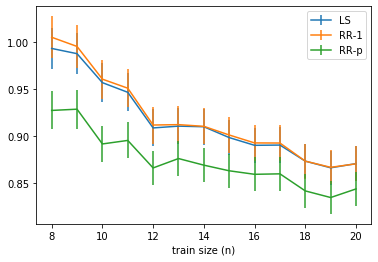

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("savefig", dpi=300)

fig = plt.figure()

for name, simulation in simulations.items():
    plt.errorbar(train_sizes, simulation['mean'], yerr=simulation['error_bar'], label=name)
    
plt.legend(loc='upper right')
plt.xlabel('train size (n)')

plt.show()